# AFL Time Series Data Analysis with Result and AFL Fantasy Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chisquare, ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stats.csv")

df.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.00,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.00,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.00,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.00,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.00,...,0,0,8,14,0,0,9,1,0,93


In [3]:
df.dtypes

Team                       object
Player                     object
D.O.B                      object
Height                      int64
Weight                      int64
Position                   object
Season                      int64
Round                      object
Date                       object
Score                     float64
Margin                    float64
WinLoss                    object
Opposition                 object
Venue                      object
Disposals                   int64
Kicks                       int64
Marks                       int64
Handballs                   int64
Goals                       int64
Behinds                     int64
Hitouts                     int64
Tackles                     int64
Rebound50s                  int64
Inside50s                   int64
Clearances                  int64
Clangers                    int64
FreesFor                    int64
FreesAgainst                int64
BrownlowVotes               int64
ContendedPosse

### Creating "Age" column:

In [4]:
#Converting date objects to datetime:
df['D.O.B'] = pd.to_datetime(df['D.O.B'], format='%Y'+'-'+'%m'+'-'+'%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y'+'-'+'%m'+'-'+'%d')

#Creating Age column:
df.insert(2,'Age',(df['Date']-df['D.O.B'])/np.timedelta64(1,'Y'))

df.drop('D.O.B',axis=1,inplace=True)

### Fixing Null Values:

In [5]:
#Removing post season "Rounds" (they also have null values)
round_list = ['QF', 'SF', 'PF', 'GF', 'EF']
df = df[~df.Round.isin(round_list)]

In [6]:
#Checking nulls
df.isnull().sum()

Team                      0
Player                    0
Age                       0
Height                    0
Weight                    0
Position                  0
Season                    0
Round                     0
Date                      0
Score                     0
Margin                    0
WinLoss                   0
Opposition                0
Venue                     0
Disposals                 0
Kicks                     0
Marks                     0
Handballs                 0
Goals                     0
Behinds                   0
Hitouts                   0
Tackles                   0
Rebound50s                0
Inside50s                 0
Clearances                0
Clangers                  0
FreesFor                  0
FreesAgainst              0
BrownlowVotes             0
ContendedPossessions      0
UncontendedPossessions    0
ContestedMarks            0
MarksInside50             0
OnePercenters             0
Bounces                   0
GoalAssists         

### Creating a alphabetically sorted "Team, Opposition" column to be able to group by game:

In [7]:
df['Teams'] = df[['Team','Opposition']].values.tolist()

In [8]:
df.Teams = df.Teams.apply(sorted).apply(', '.join)

### Creating Points Per Percent Played column:

In [9]:
#Creating "points per percent of game played" columns
df.insert(10, 'PointsPerPercentPlayed',(df['Goals']+df['Behinds'])/df['PercentPlayed'])

## Feature info:

In [10]:
df.describe()

,Age,Height,Weight,Season,Score,PointsPerPercentPlayed,Margin,Disposals,Kicks,Marks,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,...,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00
mean,24.96,187.76,88.07,2015.00,88.53,0.01,0.00,16.73,9.43,4.08,...,0.84,0.14,6.40,10.28,0.49,0.53,2.15,0.38,0.40,81.81
std,3.68,7.20,8.08,2.00,27.81,0.02,46.17,7.21,4.56,2.55,...,0.98,0.55,3.71,5.31,0.85,0.99,2.33,0.93,0.68,13.32
min,18.27,167.00,67.00,2012.00,17.00,0.00,-162.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,22.07,183.00,82.00,2013.00,69.00,0.00,-30.00,11.00,6.00,2.00,...,0.00,0.00,4.00,6.00,0.00,0.00,1.00,0.00,0.00,79.00
50%,24.61,187.00,86.00,2015.00,86.00,0.00,0.00,16.00,9.00,4.00,...,1.00,0.00,6.00,10.00,0.00,0.00,1.00,0.00,0.00,84.00
75%,27.49,193.00,93.00,2017.00,106.00,0.02,30.00,21.00,12.00,6.00,...,1.00,0.00,8.00,14.00,1.00,1.00,3.00,0.00,1.00,89.00
max,41.26,211.00,118.00,2018.00,193.00,0.25,162.00,54.00,36.00,21.00,...,8.00,3.00,32.00,40.00,8.00,13.00,25.00,15.00,6.00,100.00


In [11]:
number_list = df.select_dtypes(include=['number']).columns

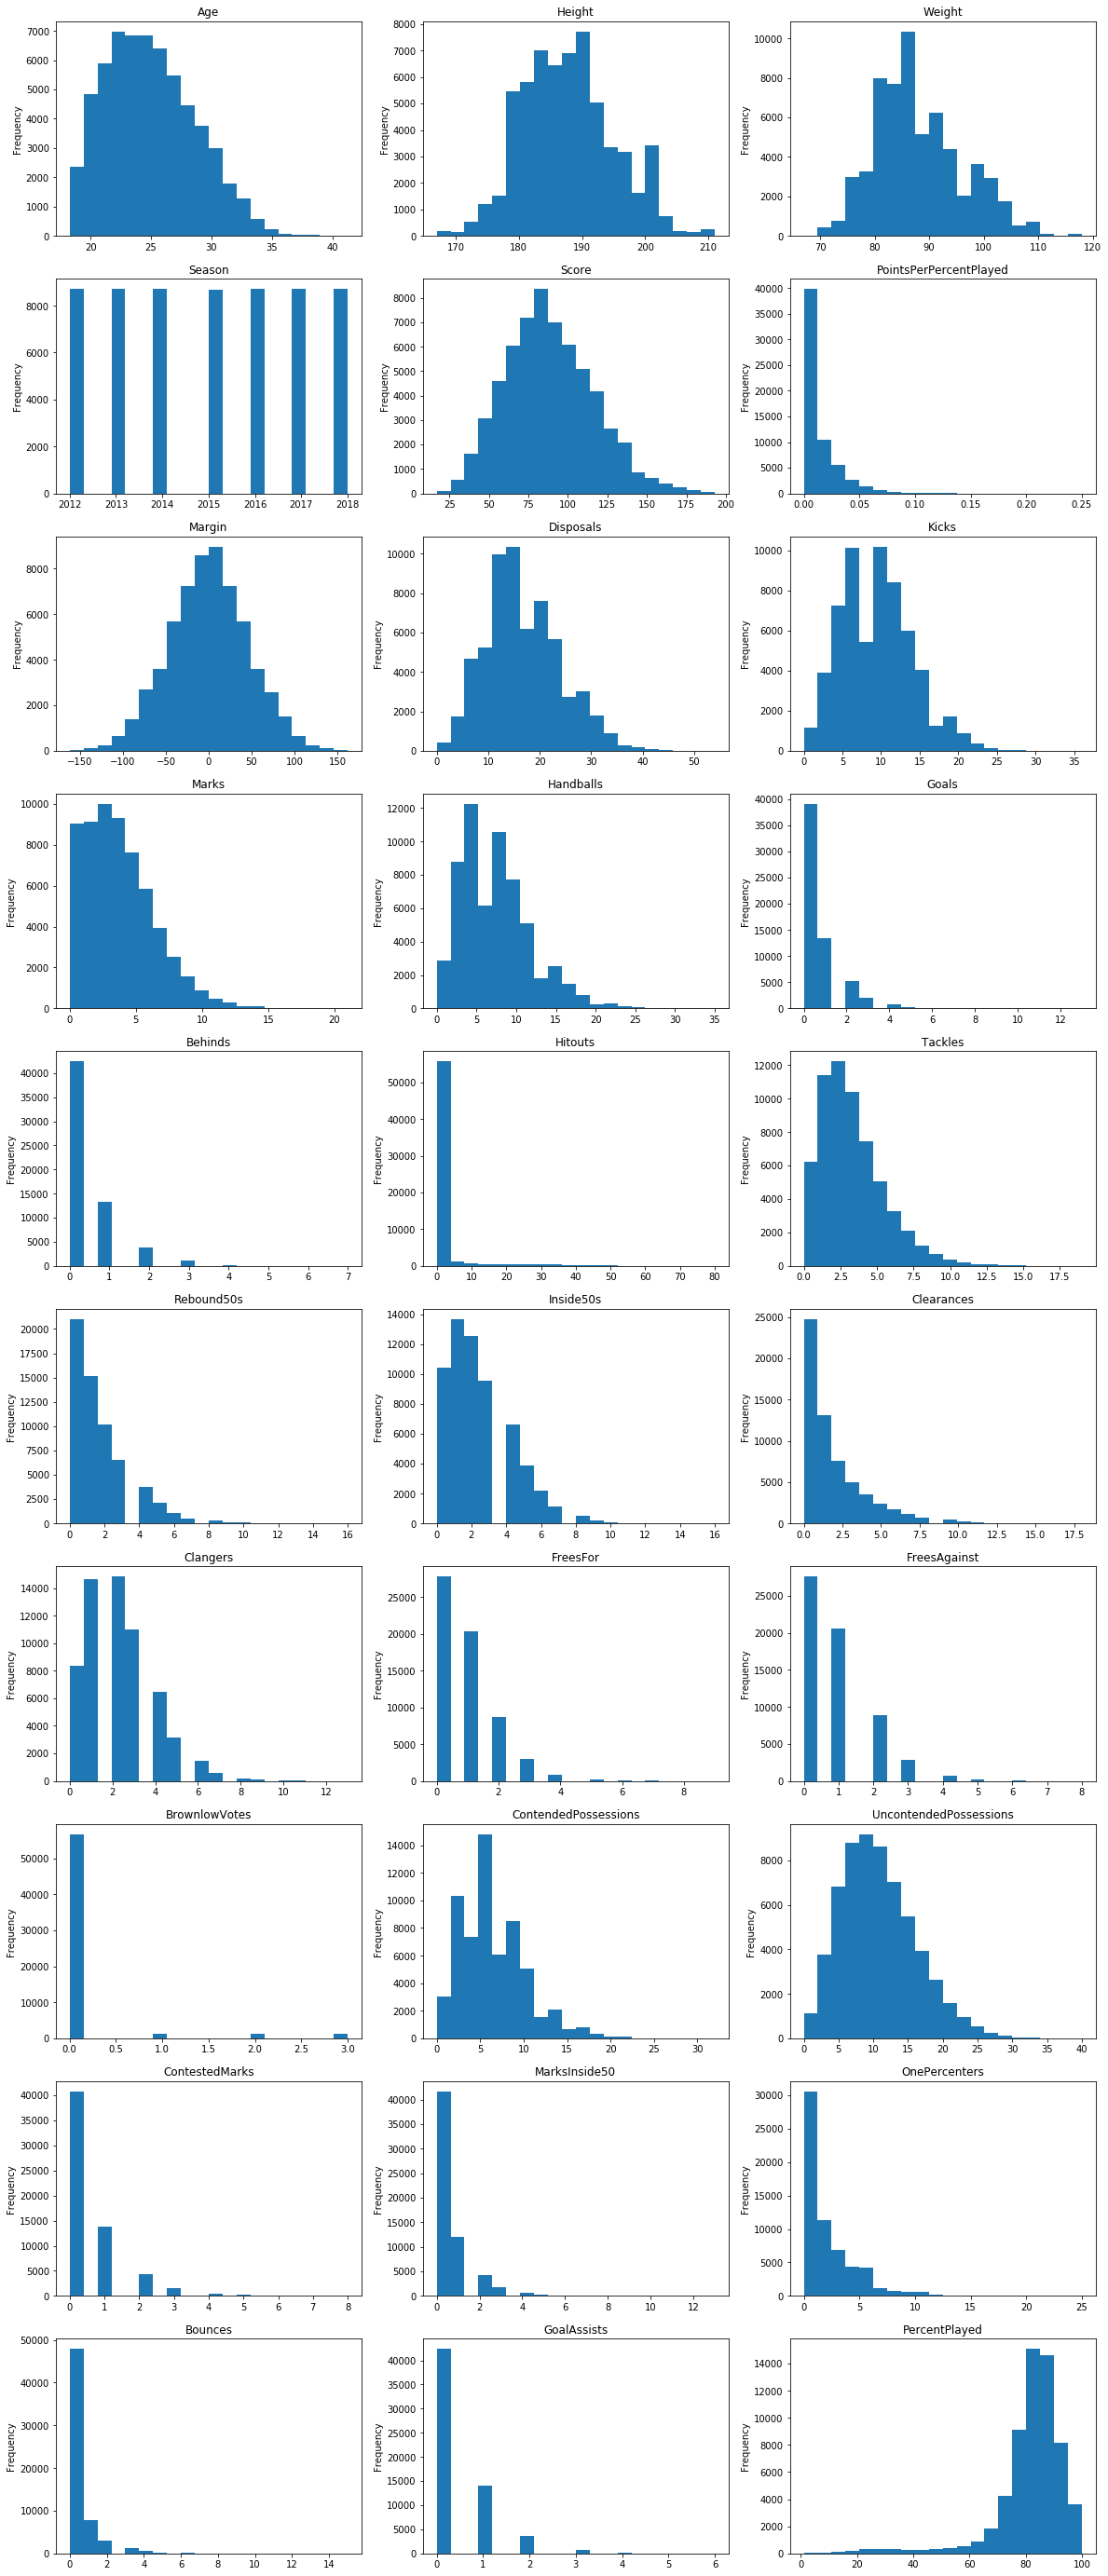

In [12]:
fig,ax = plt.subplots(10, 3)

m=0
for i in range(10):
    for j in range(3):

        df[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],figsize=(20, 50)).set_title(number_list[m])
        m+=1

In [13]:
df = df.set_index(['Season','Round']).sort_index()

In [14]:
scaling_list = ['PointsPerPercentPlayed','Disposals', 'Kicks', 'Marks','Handballs',
                'Goals', 'Behinds','Hitouts', 'Tackles', 'Rebound50s','Inside50s',
                'Clearances','Clangers', 'FreesFor', 'FreesAgainst','BrownlowVotes',
                'ContendedPossessions', 'UncontendedPossessions','ContestedMarks',
                'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists']

In [15]:
normalize_list = ['Age', 'Height', 'Weight', 'Score', 'Margin']

In [16]:
df_ML = df.copy()

## Normalizing all players by round:

In [17]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [18]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))

# Comparing points made per percent of game to various characteristics relative to all players that round:

In [19]:
print(df_ML.Position.value_counts())

hist_names = df_ML.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


## Age:

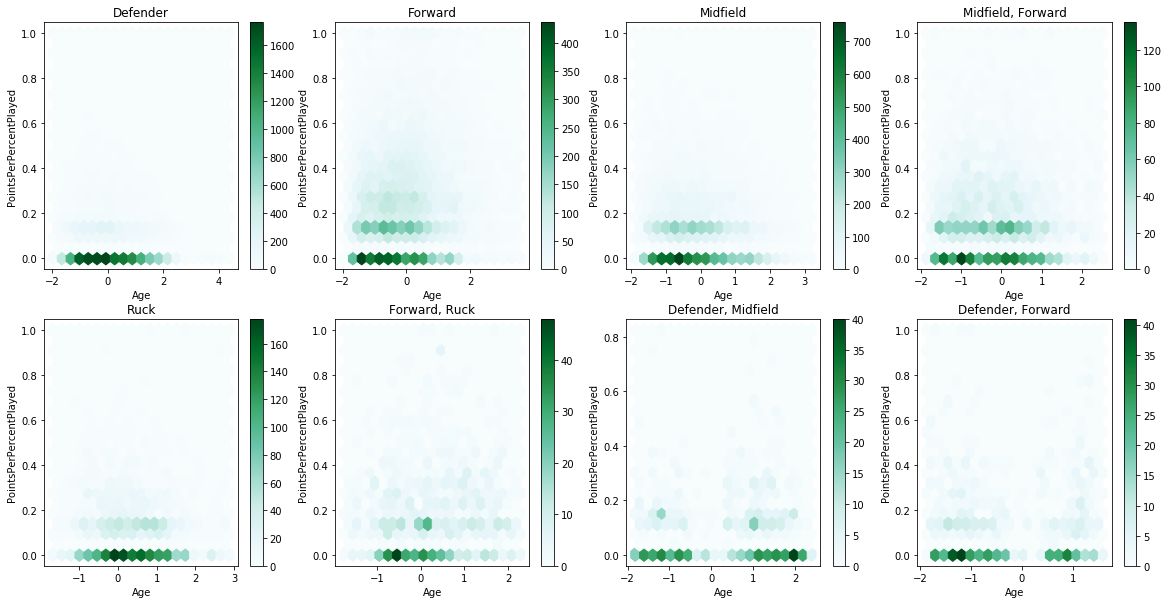

In [20]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Age','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

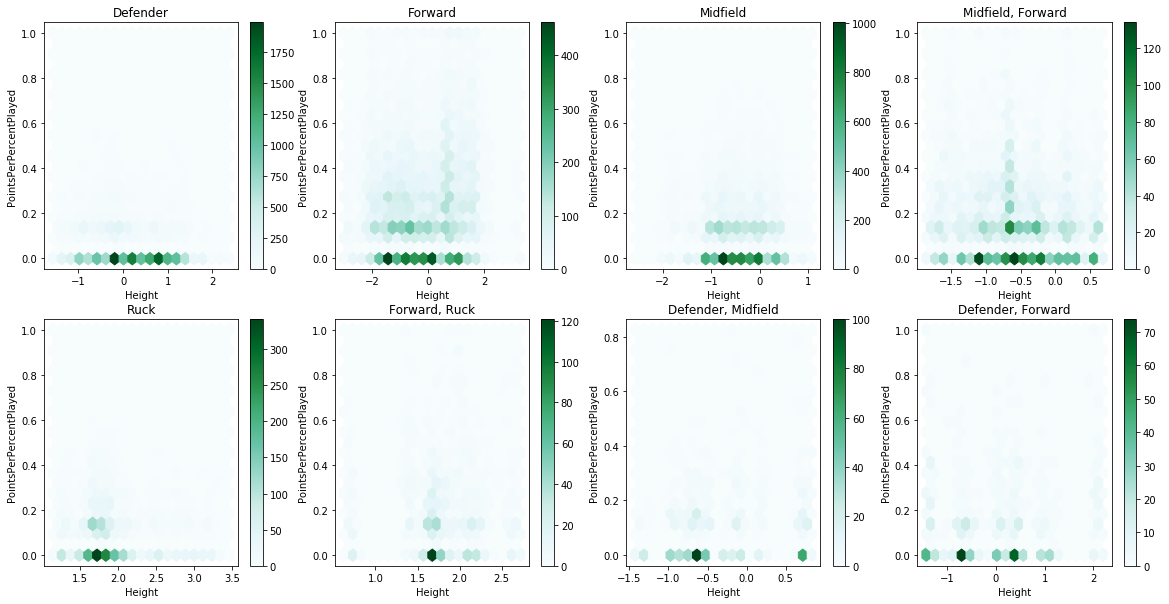

In [21]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Height','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

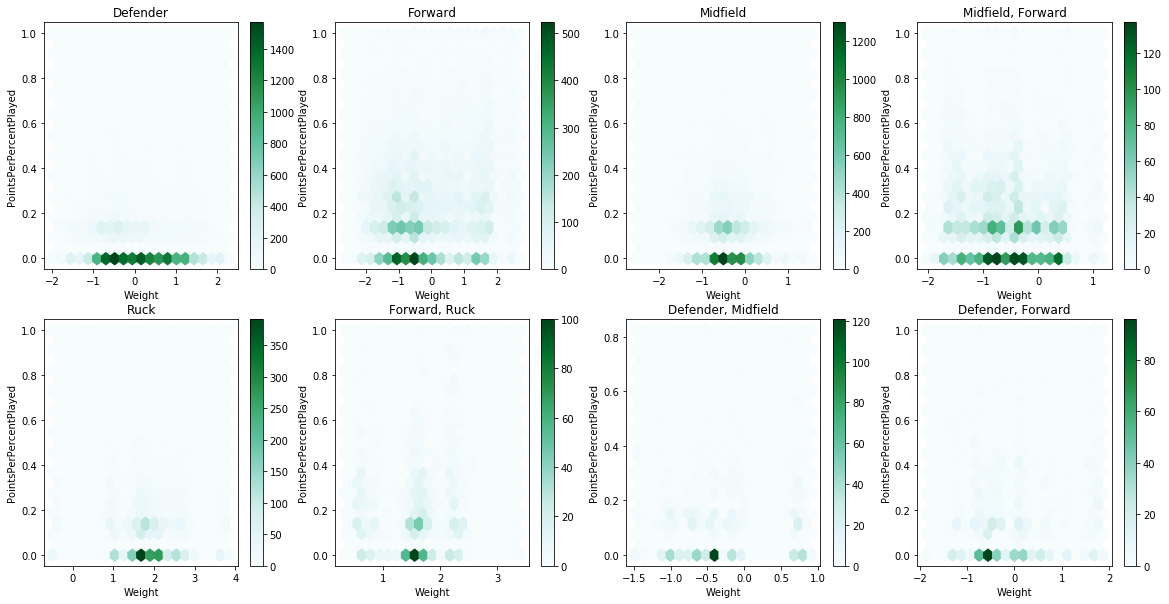

In [22]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Weight','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Normalizing further by game:

In [23]:
df_ML = df_ML.set_index(['Teams'],append=1).sort_index()

In [24]:
for col in scaling_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [25]:
for col in normalize_list:
    df_ML[col] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))

In [26]:
df_ML.fillna(0,inplace=True)

In [27]:
#Changing WinLoss to numerical values
df_ML.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

In [28]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Season','Round'],axis=1,inplace=True)

df_ML.set_index(['Date','Teams','Team'],inplace=True)
df_ML.sort_index(inplace=True)

# Comparing points made per percent of game to various characteristics relative to players in each game:

## Age:

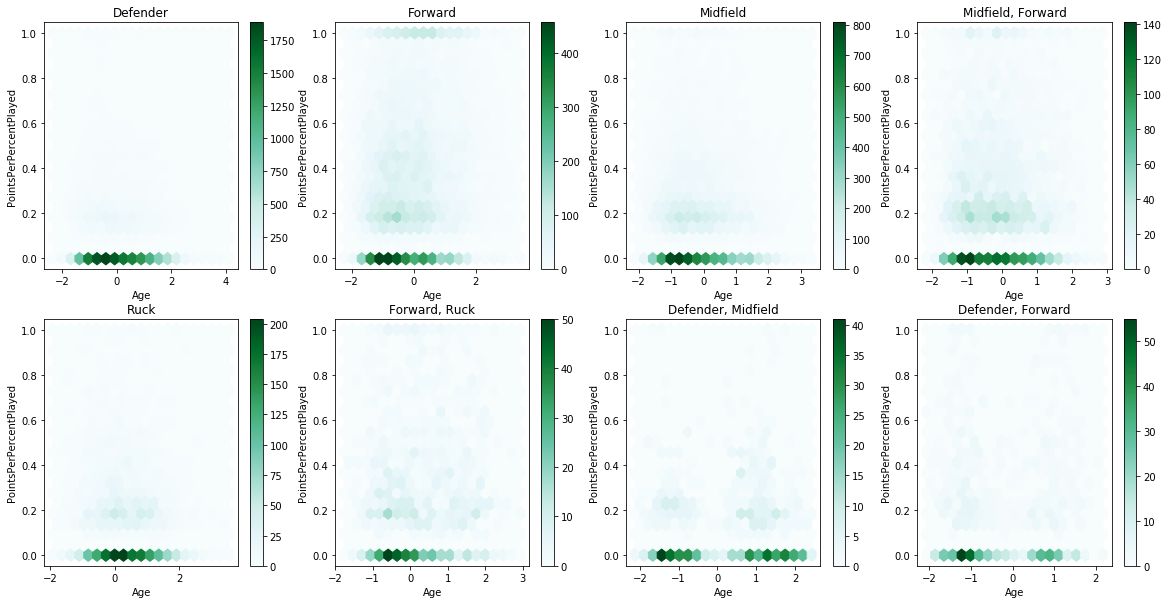

In [29]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Age','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

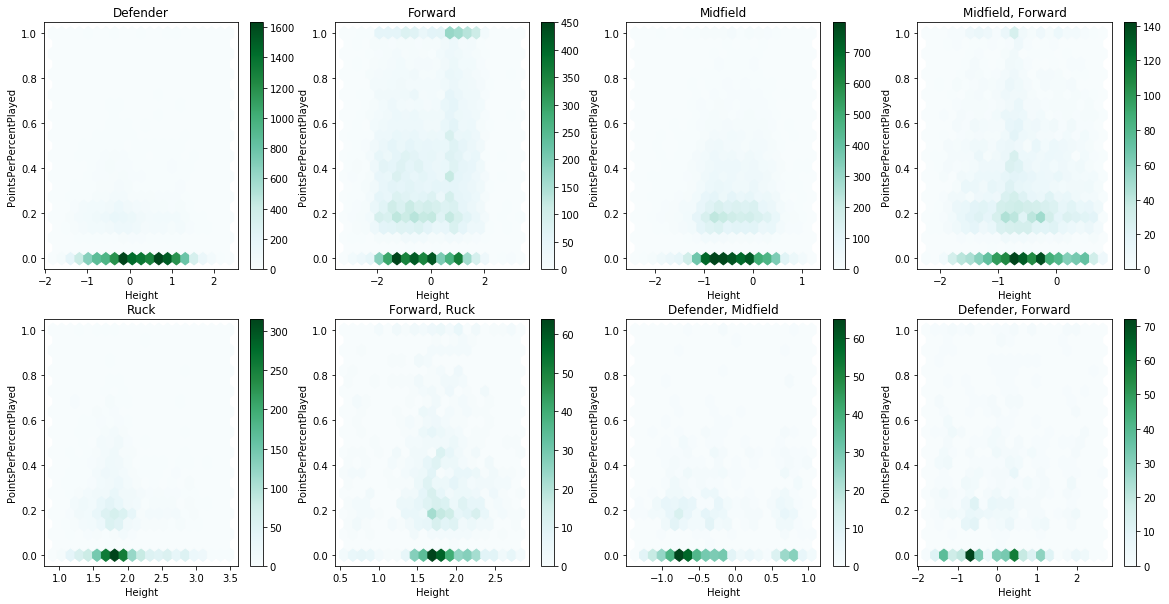

In [30]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Height','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

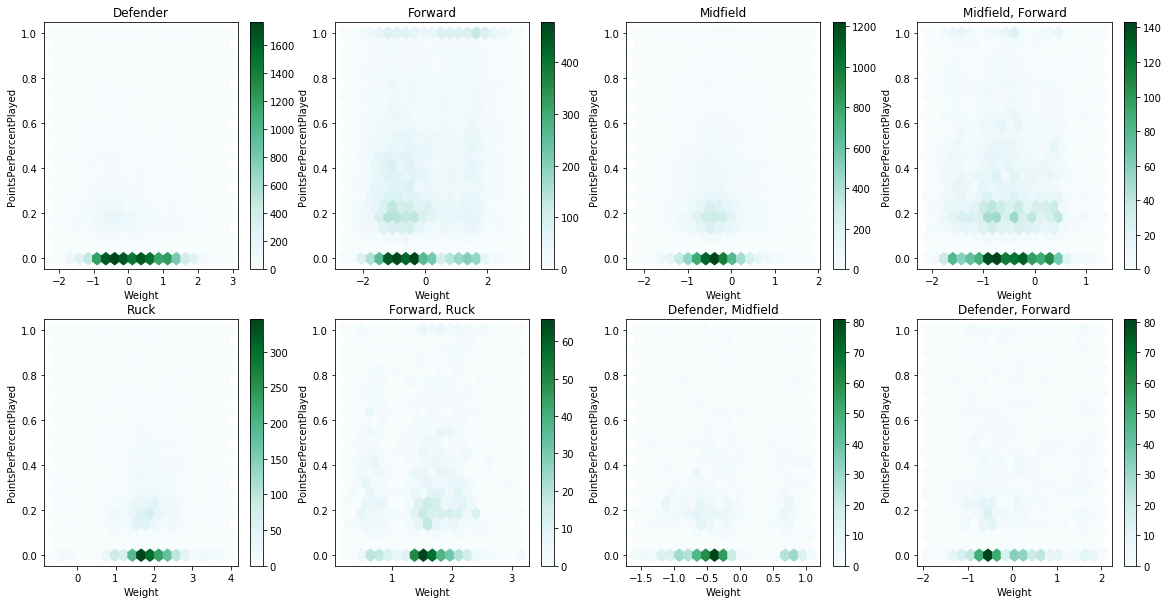

In [31]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_ML[df_ML.Position==hist_names[m]].plot.hexbin('Weight','PointsPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Scaling the data by the percent played:

In [32]:
number_list = scaling_list+normalize_list
number_list

['PointsPerPercentPlayed',
 'Disposals',
 'Kicks',
 'Marks',
 'Handballs',
 'Goals',
 'Behinds',
 'Hitouts',
 'Tackles',
 'Rebound50s',
 'Inside50s',
 'Clearances',
 'Clangers',
 'FreesFor',
 'FreesAgainst',
 'BrownlowVotes',
 'ContendedPossessions',
 'UncontendedPossessions',
 'ContestedMarks',
 'MarksInside50',
 'OnePercenters',
 'Bounces',
 'GoalAssists',
 'Age',
 'Height',
 'Weight',
 'Score',
 'Margin']

In [33]:
df_ML[number_list] = df_ML[number_list].multiply(df_ML.PercentPlayed/100,axis=0)

In [34]:
df_ML[number_list] = df_ML[number_list].groupby(['Date','Teams','Team']).mean()

## Offsetting columns for time series analysis:

In [35]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Player','Position','PercentPlayed','Opposition','Teams'],axis=1,inplace=True)
df_ML.drop_duplicates(inplace=True)

In [36]:
Offset_List = ['Score','PointsPerPercentPlayed','Margin','WinLoss','Disposals',
               'Kicks','Marks','Handballs', 'Goals','Behinds','Hitouts','Tackles',
               'Rebound50s', 'Inside50s', 'Clearances','Clangers','FreesFor',
               'FreesAgainst', 'BrownlowVotes','ContendedPossessions', 
               'UncontendedPossessions', 'ContestedMarks','MarksInside50',
               'OnePercenters', 'Bounces', 'GoalAssists']

In [37]:
PointsList=[]

for column_name in Offset_List:
    df_ML[column_name+'1'] = df_ML.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Team')[column_name].shift().reset_index(['Date'], drop=1)

    PointsList.append(column_name+'1')

    for i in range(2,7):
        df_ML[column_name+str(i)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Team')[column_name].rolling(window=i,min_periods=i).mean()\
            .groupby('Team').shift().reset_index(['Team','Date'], drop=1)

        PointsList.append(column_name+str(i))

In [38]:
Offset_List.remove('WinLoss')

df_ML.drop(Offset_List,axis=1,inplace=True)

In [39]:
#Fixing nulls again because of shifting:
df_ML.fillna(0,inplace=True)

# Machine Learning:
## Making dummy variables:

In [40]:
df_ML.select_dtypes(include=['object']).head()

,Team,Venue
0,Greater Western Sydney,Stadium Australia
22,Sydney,Stadium Australia
44,Carlton,M.C.G.
66,Richmond,M.C.G.
88,Collingwood,M.C.G.


In [41]:
categorical_list = df_ML.select_dtypes(include=['object']).drop('Team',axis=1).columns

In [42]:
df_ML = pd.get_dummies(df_ML,columns=categorical_list,drop_first=True)

In [43]:
df_ML=df_ML[df_ML.WinLoss!=.5]

In [44]:
df_ML.head()

,Date,Team,Age,Height,Weight,WinLoss,Score1,Score2,Score3,Score4,...,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park
0,2012-03-24,Greater Western Sydney,-0.28,0.09,0.03,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
22,2012-03-24,Sydney,0.39,0.02,0.10,1.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
44,2012-03-29,Carlton,0.16,-0.01,-0.00,1.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
66,2012-03-29,Richmond,-0.14,0.05,0.03,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
88,2012-03-30,Collingwood,-0.14,0.04,0.16,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


## Spliting Data and Creating Model:

In [45]:
X = df_ML.drop(['WinLoss','Date','Team'],axis=1)
y = df_ML['WinLoss']

In [46]:
#classifiers
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

#for function below
from sklearn.model_selection import StratifiedKFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [47]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=StratifiedKFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
    
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [48]:
clf_A = LogisticRegression(solver='liblinear',random_state=0)

clf_B = RandomForestClassifier(n_estimators=200,random_state=0,max_depth=7)

clf_C = DecisionTreeClassifier(random_state=0,max_depth=2)

clf_D = xgb.XGBClassifier(n_estimators=200,random_state=0,max_depth=2)

In [49]:
FOLD_TEST(clf_A, X, y, 5, 1)

LogisticRegression: 

Averages:

Train acc: 0.6793225992899017, Test acc: 0.6671343873517787
Train prc: 0.6749106625963688, Test prc: 0.6626695506903411
Train recall: 0.6920401288085212, Test recall: 0.6809380764163373 

Train f1: 0.6833569336140793, Test f1: 0.6715889099616099
Train MattCC: 0.3587722795654021, Test MattCC: 0.33448343000582953
Train AUC: 0.6793225992899017, Test AUC: 0.6671343873517787 


Sample Size: 2752, Folds Num: 5, Time: 0.5666487216949463 




In [50]:
FOLD_TEST(clf_B, X, y, 5, 1)

RandomForestClassifier: 

Averages:

Train acc: 0.8818136404921146, Test acc: 0.6395243741765481
Train prc: 0.8547517231329074, Test prc: 0.6211656697820144
Train recall: 0.9202389563207001, Test recall: 0.7173096179183135 

Train f1: 0.8862120463293017, Test f1: 0.6653669634573468
Train MattCC: 0.7660359570037656, Test MattCC: 0.28296359928463544
Train AUC: 0.8818136404921146, Test AUC: 0.6395243741765481 


Sample Size: 2752, Folds Num: 5, Time: 10.300875902175903 




In [51]:
FOLD_TEST(clf_C, X, y, 5, 1)

DecisionTreeClassifier: 

Averages:

Train acc: 0.6569761373957559, Test acc: 0.6460737812911725
Train prc: 0.6356747765460946, Test prc: 0.6254873458662911
Train recall: 0.7445571794236645, Test recall: 0.7376073781291173 

Train f1: 0.6835426622270415, Test f1: 0.6748908932988184
Train MattCC: 0.32167942681277806, Test MattCC: 0.2998243467020951
Train AUC: 0.6569761373957559, Test AUC: 0.6460737812911725 


Sample Size: 2752, Folds Num: 5, Time: 0.5106844902038574 




In [52]:
FOLD_TEST(clf_D, X, y, 5, 1)

XGBClassifier: 

Averages:

Train acc: 0.8141348360994136, Test acc: 0.6518761528326745
Train prc: 0.808354145261689, Test prc: 0.6473541533437727
Train recall: 0.8235823631409461, Test recall: 0.6671357048748353 

Train f1: 0.8158899337912306, Test f1: 0.6570409936380326
Train MattCC: 0.6283922578529048, Test MattCC: 0.3039478831434804
Train AUC: 0.8141348360994136, Test AUC: 0.6518761528326745 


Sample Size: 2752, Folds Num: 5, Time: 12.056572675704956 




# Predicting AFL Fantasy points:

In [53]:
df_F = df.copy()
fantasy_points = {'Kicks':3,'Handballs':2,'Marks':3,'Tackles':4,'FreesFor':1,
                  'FreesAgainst':-3,'Hitouts':1,'Goals':6,'Behinds':1}

In [54]:
new_list=[]

#Creating fantasy columns
for keys in fantasy_points.keys():
    df_F[keys+'_fantasy'] = df_F[keys]*fantasy_points[keys]
    new_list.append(keys+'_fantasy')
    
df_F['fantasy_points'] = pd.Series()   
    
for cols in fantasy_points.keys():
    df_F.fantasy_points = df_F.fantasy_points.add(df_F[cols+'_fantasy'],fill_value=0)

df_F['target'] = df_F.fantasy_points

In [55]:
df_F[new_list+['fantasy_points']].head()

Kicks_fantasy  Handballs_fantasy  Marks_fantasy  \
Season Round                                                    
2012   R1                42                  8             15   
       R1                39                 24              9   
       R1                15                 24             12   
       R1                42                 10             18   
       R1                15                  6              3   

              Tackles_fantasy  FreesFor_fantasy  FreesAgainst_fantasy  \
Season Round                                                            
2012   R1                  20                 0                    -3   
       R1                   8                 0                    -3   
       R1                  12                 2                     0   
       R1                  28                 2                     0   
       R1                   4                 0                     0   

              Hitouts_fantasy  Goals_fantasy  Behinds_fantasy  fantasy_points  
Season Round                                                                   
2012   R1                   0             12                5           99.00  
       R1                   0             12                0           89.00  
       R1                   0              0                0           65.00  
       R1                   0              6                3          109.00  
       R1                   0              0                0           28.00

In [56]:
df_F.insert(11, 'FantasyPerPercentPlayed',df_F['fantasy_points']/df_F['PercentPlayed'])

In [57]:
new_scaling_list = scaling_list + new_list + ['fantasy_points'] + ['FantasyPerPercentPlayed']

## Normalizing all players by round:

In [58]:
for col in new_scaling_list:
    df_F[col] = df_F.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [59]:
for col in normalize_list:
    df_F[col] = df_F.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))

# Comparing fantasy points made per percent of game to various characteristics relative to all players that round:

## Age:

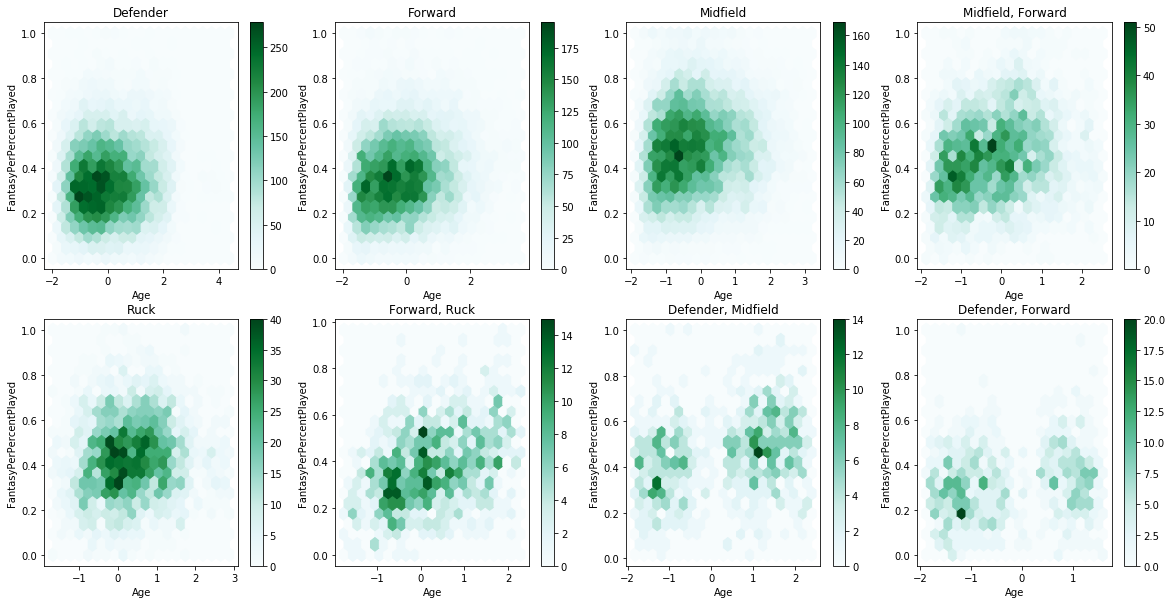

In [60]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Age','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

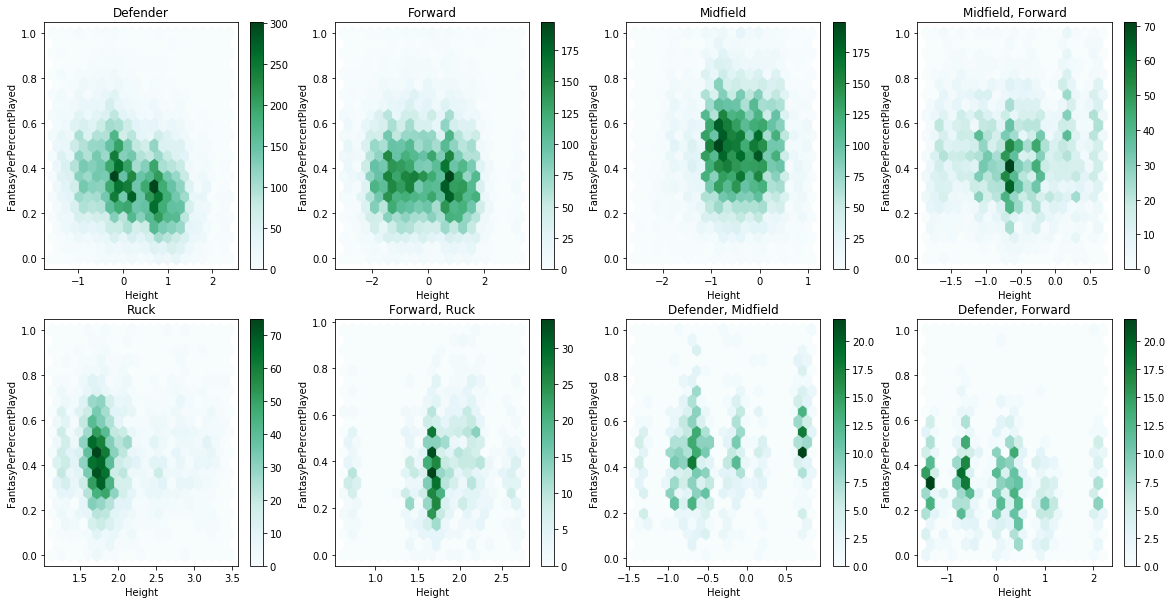

In [61]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Height','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

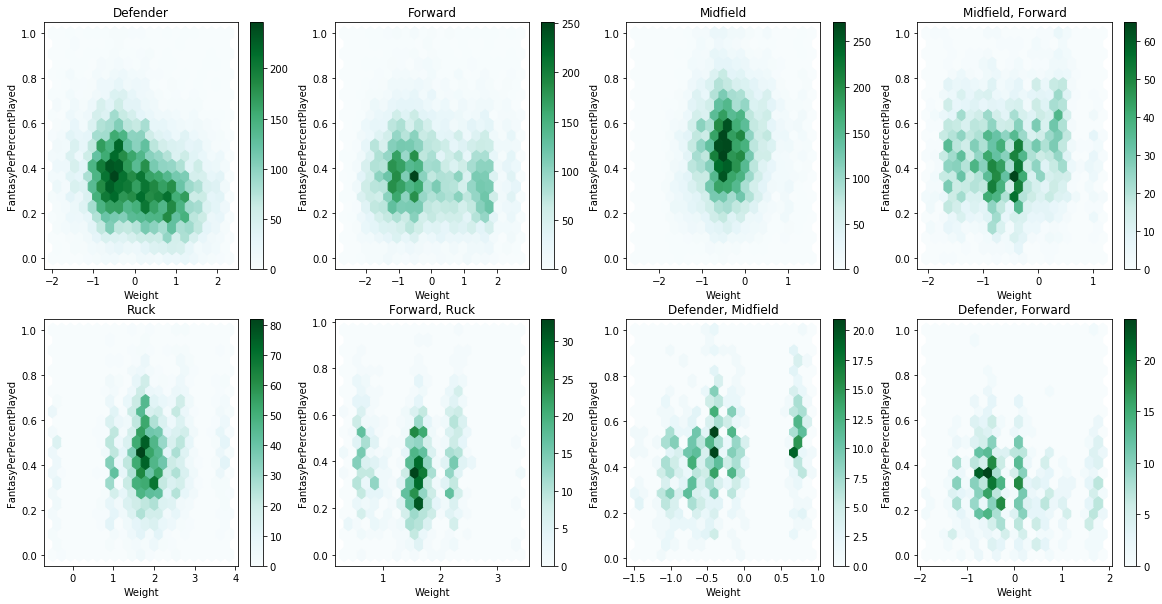

In [62]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Weight','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Normalizing further by game:

In [63]:
df_F = df_F.set_index(['Teams'],append=1).sort_index()

In [64]:
for col in new_scaling_list:
    df_F[col] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))

In [65]:
for col in normalize_list:
    df_F[col] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))

In [66]:
df_F.fillna(0,inplace=True)

In [67]:
df_F.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

In [68]:
df_F.reset_index(inplace=True)
df_F.drop(['Season','Round'],axis=1,inplace=True)

df_F.set_index(['Date','Teams','Team'],inplace=True)
df_F.sort_index(inplace=True)

# Comparing fantasy points made per percent of game to various characteristics relative to players in each game:

## Age:

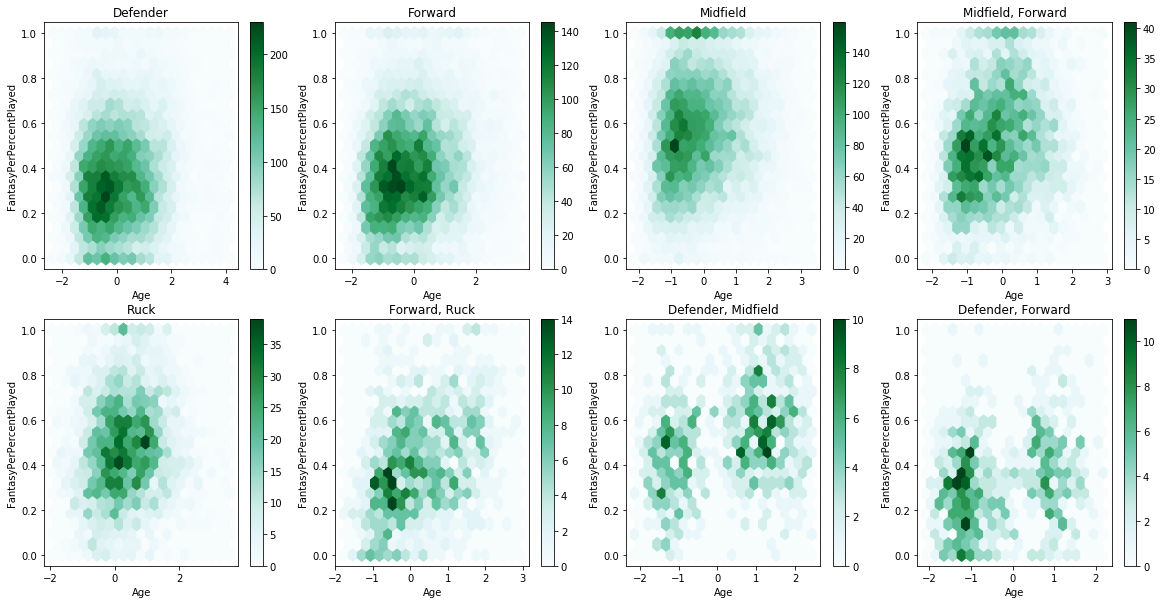

In [69]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Age','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Height:

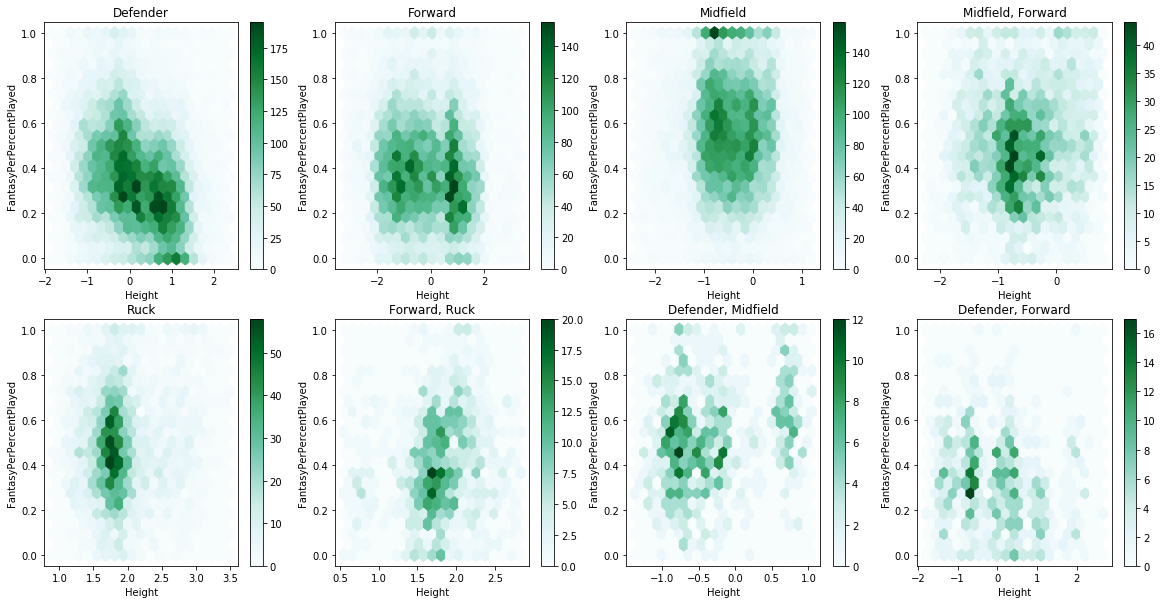

In [70]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Height','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Weight:

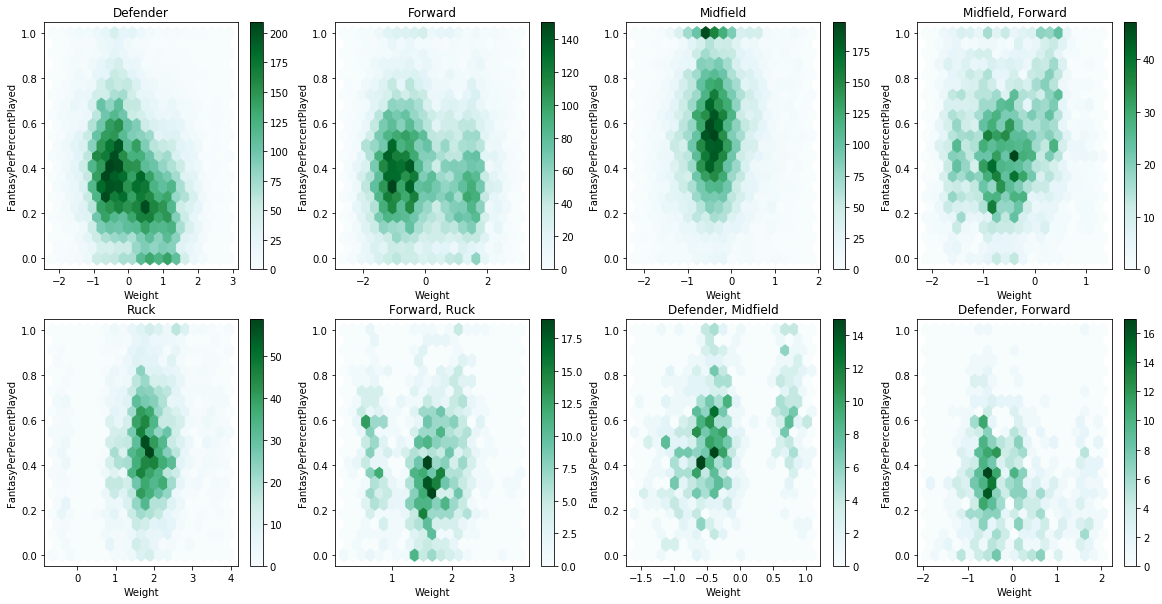

In [71]:
fig,ax = plt.subplots(2, 4)

m=0
for i in range(2):
    for j in range(4):

        df_F[df_F.Position==hist_names[m]].plot.hexbin('Weight','FantasyPerPercentPlayed',
                                                   ax=ax[i,j],figsize=(20, 10),
                                                   gridsize=20).set_title(hist_names[m])
        m+=1

## Scaling the data by the percent played:

In [72]:
new_number_list = new_scaling_list+normalize_list
new_number_list

['PointsPerPercentPlayed',
 'Disposals',
 'Kicks',
 'Marks',
 'Handballs',
 'Goals',
 'Behinds',
 'Hitouts',
 'Tackles',
 'Rebound50s',
 'Inside50s',
 'Clearances',
 'Clangers',
 'FreesFor',
 'FreesAgainst',
 'BrownlowVotes',
 'ContendedPossessions',
 'UncontendedPossessions',
 'ContestedMarks',
 'MarksInside50',
 'OnePercenters',
 'Bounces',
 'GoalAssists',
 'Kicks_fantasy',
 'Handballs_fantasy',
 'Marks_fantasy',
 'Tackles_fantasy',
 'FreesFor_fantasy',
 'FreesAgainst_fantasy',
 'Hitouts_fantasy',
 'Goals_fantasy',
 'Behinds_fantasy',
 'fantasy_points',
 'FantasyPerPercentPlayed',
 'Age',
 'Height',
 'Weight',
 'Score',
 'Margin']

In [73]:
df_F[new_number_list] = df_F[new_number_list].multiply(df_F.PercentPlayed/100,axis=0)

## Offsetting columns for time series analysis:

In [74]:
df_F.reset_index(inplace=True)
df_F.drop(['Teams','PercentPlayed'],axis=1,inplace=True)

In [75]:
Offset_Fantasy_List = ['Score','PointsPerPercentPlayed','FantasyPerPercentPlayed','Margin','WinLoss',
                       'Disposals','Kicks','Marks','Handballs','Goals','Behinds','Hitouts','Tackles',
                       'Rebound50s','Inside50s','Clearances','Clangers','FreesFor','FreesAgainst',
                       'BrownlowVotes','ContendedPossessions','UncontendedPossessions','ContestedMarks',
                       'MarksInside50','OnePercenters','Bounces','GoalAssists','fantasy_points',
                       'Kicks_fantasy','Handballs_fantasy','Marks_fantasy','Tackles_fantasy',
                       'FreesFor_fantasy','FreesAgainst_fantasy','Hitouts_fantasy','Goals_fantasy',
                       'Behinds_fantasy']

In [76]:
FantasyList=[]

for column_name in Offset_Fantasy_List:
    df_F[column_name+'1'] = df_F.set_index('Date',append=1).sort_index(level=1)\
        .groupby('Player')[column_name].shift().reset_index(['Date'], drop=1)

    FantasyList.append(column_name+'1')

    for i in range(2,7):
        df_F[column_name+str(i)] = df_F.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Player')[column_name].rolling(window=i,min_periods=i).mean()\
            .groupby('Player').shift().reset_index(['Player','Date'], drop=1)

        FantasyList.append(column_name+str(i))

In [77]:
df_F.drop(Offset_Fantasy_List,axis=1,inplace=True)

In [78]:
#Fixing nulls again because of shifting:
df_F.fillna(0,inplace=True)

# Machine Learning:
## Making dummy variables:

In [79]:
df_F.select_dtypes(include=['object']).head()

,Team,Player,Position,Opposition,Venue
0,Greater Western Sydney,"Bugg, Tomas",Midfield,Sydney,Stadium Australia
1,Greater Western Sydney,"Cameron, Jeremy",Forward,Sydney,Stadium Australia
2,Greater Western Sydney,"Coniglio, Stephen",Midfield,Sydney,Stadium Australia
3,Greater Western Sydney,"Cornes, Chad",Defender,Sydney,Stadium Australia
4,Greater Western Sydney,"Davis, Phil",Defender,Sydney,Stadium Australia


In [80]:
categorical_list2 = df_F.select_dtypes(include=['object']).drop('Player',axis=1).columns

In [81]:
df_F = pd.get_dummies(df_F,columns=categorical_list2,drop_first=True)

In [82]:
df_F.dtypes

Date                           datetime64[ns]
Player                                 object
Age                                   float64
Height                                float64
Weight                                float64
target                                float64
Score1                                float64
Score2                                float64
Score3                                float64
Score4                                float64
Score5                                float64
Score6                                float64
PointsPerPercentPlayed1               float64
PointsPerPercentPlayed2               float64
PointsPerPercentPlayed3               float64
PointsPerPercentPlayed4               float64
PointsPerPercentPlayed5               float64
PointsPerPercentPlayed6               float64
FantasyPerPercentPlayed1              float64
FantasyPerPercentPlayed2              float64
FantasyPerPercentPlayed3              float64
FantasyPerPercentPlayed4          

In [83]:
df_F.head()

,Date,Player,Age,Height,Weight,target,Score1,Score2,Score3,Score4,...,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Perth Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park
0,2012-03-24,"Bugg, Tomas",-0.72,-0.40,-0.43,97.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
1,2012-03-24,"Cameron, Jeremy",-0.84,1.25,0.87,39.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
2,2012-03-24,"Coniglio, Stephen",-0.85,-0.65,-0.23,53.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
3,2012-03-24,"Cornes, Chad",1.85,0.51,0.51,111.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
4,2012-03-24,"Davis, Phil",-0.31,1.37,0.86,62.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0


## Spliting Data and Creating Model:

In [84]:
X2 = df_F.drop(['target','Date','Player'],axis=1)
y2 = df_F['target']

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor,Ridge
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import r2_score

In [86]:
clf_A = SGDRegressor(random_state=0)

clf_D = Ridge(random_state=0)

clf_F = LinearSVR(random_state=0)

clf_G = DecisionTreeRegressor(random_state=0,max_depth=2)

clf_H = RandomForestRegressor(random_state=0,max_depth=7)

clf_J = MLPRegressor(random_state=0)

clf_K = xgb.XGBRegressor(random_state=0,max_depth=2)

In [87]:
def metrics_function(target,pred):
    return r2_score(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    samp_size=X_all.shape[0]//row_factor
    
    R2_list_train=[]
    R2_list_test=[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_R2=metrics_function(y_train,y_pred1)
        test_R2=metrics_function(y_test,y_pred2)
        
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
   
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [88]:
FOLD_TEST(clf_A, X2, y2, 5, 1)

SGDRegressor: 

Train R2: 0.3052113149875238, Test R2: 0.30176866298119676 


Sample Size: 60940, Folds Num: 5, Time: 2.6601011753082275 




In [89]:
FOLD_TEST(clf_D, X2, y2, 5, 1)

Ridge: 

Train R2: 0.3141011699090284, Test R2: 0.30721288015323955 


Sample Size: 60940, Folds Num: 5, Time: 1.9550812244415283 




In [90]:
FOLD_TEST(clf_F, X2, y2, 5, 1)

LinearSVR: 

Train R2: 0.3114204388971213, Test R2: 0.3063177423842195 


Sample Size: 60940, Folds Num: 5, Time: 6.369713068008423 




In [91]:
FOLD_TEST(clf_G, X2, y2, 5, 1)

DecisionTreeRegressor: 

Train R2: 0.2478802636662339, Test R2: 0.24522381395173393 


Sample Size: 60940, Folds Num: 5, Time: 8.627804040908813 




In [92]:
FOLD_TEST(clf_H, X2, y2, 5, 1)

RandomForestRegressor: 

Train R2: 0.3430729018066154, Test R2: 0.30194859031000876 


Sample Size: 60940, Folds Num: 5, Time: 162.87025570869446 




In [93]:
FOLD_TEST(clf_J, X2, y2, 5, 1)

MLPRegressor: 

Train R2: 0.43468015680758026, Test R2: 0.2763929861638348 


Sample Size: 60940, Folds Num: 5, Time: 674.3149988651276 




In [94]:
FOLD_TEST(clf_K, X2, y2, 5, 1)

XGBRegressor: 

Train R2: 0.3264220020821728, Test R2: 0.3157926362836817 


Sample Size: 60940, Folds Num: 5, Time: 159.52981519699097 


